## IMPORT LIBRARIES

In [2]:
import tensorflow as tf
import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
!pip install mat73
import mat73
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD ORIGINAL TRAINING DATA

In [3]:
n=5000
import random

fn= f'/content/drive/MyDrive/Colab Notebooks/UNet Model/MW256.mat'
mat = mat73.loadmat(fn)['MW256']
selectindex=random.sample(range(0, mat.shape[2]), n)
ytrain = np.zeros([n,256,256], dtype=np.single)
for i in range(n):
   ytrain[i,:,:]=mat[:,:,selectindex[i]]
mat=[]

In [4]:
fn= f'/content/drive/MyDrive/Colab Notebooks/UNet Model/IR256.mat'
mat = mat73.loadmat(fn)['IR256']
xtrain1 = np.zeros([n,256,256], dtype=np.uint8)
for i in range(n):
   xtrain1[i,:,:]=mat[:,:,selectindex[i]]
mat=[]

In [5]:
dataset=np.stack([xtrain1,ytrain],-1)
print(dataset.shape)

(5000, 256, 256, 2)


In [6]:
xtrain1,ytrain=[],[]

In [7]:
train_size =4000
test_size =1000
train= dataset[:train_size,...]
test = dataset[train_size:train_size+test_size,...]

np.save(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/train_dataset.npy',train)
np.save(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/test_dataset.npy',test)
dataset=[]

# LOAD PROCESSED TRAINING DATA



In [8]:
## New Pipeline (disconect the runtime and run this pipline instead of old pipeline to compare)
train = np.load(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/train_dataset.npy')
test = np.load(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/test_dataset.npy')
print(train.shape)

(4000, 256, 256, 2)


In [9]:
BATCH_SIZE = 8
def data_generator(data):
    for i in range(data.shape[0]):
        yield data[i]

def load(input):
  input_image = tf.convert_to_tensor(tf.reshape((input[...,0]-1)/254.0,[256,256,1]))
  real_image = tf.convert_to_tensor(tf.reshape(input[...,1],[256,256,1]))
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  return input_image, real_image

train_dataset = tf.data.Dataset.from_generator(lambda: data_generator(train), output_types=tf.float32)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(lambda: data_generator(test), output_types=tf.float32)
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Instructions for updating:
Use output_signature instead


In [10]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

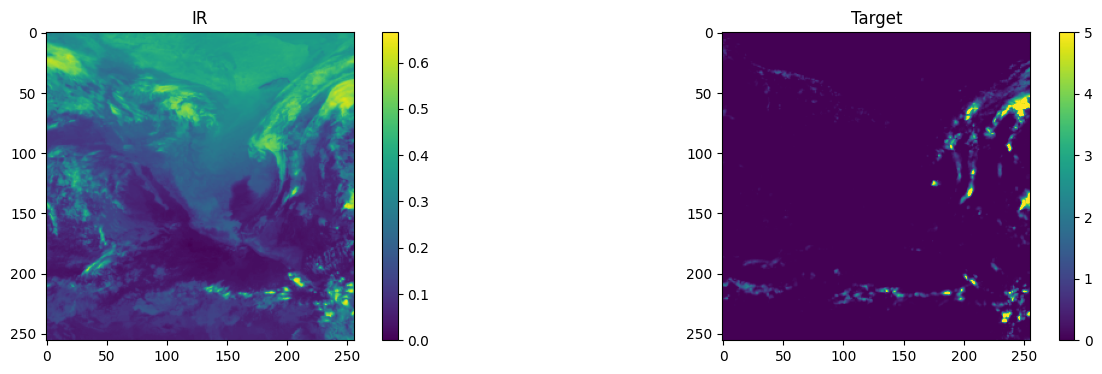

0.0


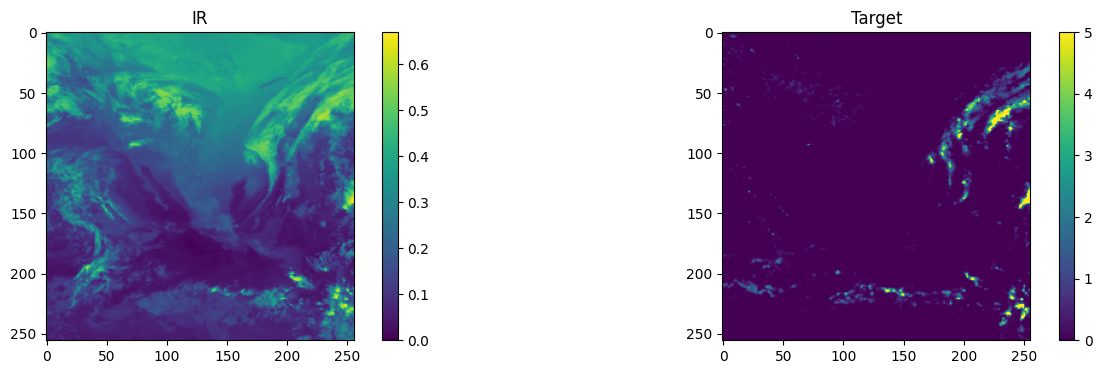

0.0


In [11]:
##Display images
for input_image, target_image in test_dataset.take(2):
    # Display the input and target images side-by-side
    fig = plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0,...,0])
    plt.title('IR')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(target_image[0,...,0])
    plt.title('Target')
    plt.colorbar()
    plt.clim(0,5)
    plt.show()
    print(np.min(target_image[0,...,0]))

##BUILD THE UNET MODEL

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model

# Define the input shape for 2D data
input_shape = (256, 256, 1)

# Define input layer
input_data = Input(shape=input_shape, name='input_data')

# U-Net Encoder
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_data)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Bottleneck layer
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

# U-Net Decoder
up3 = UpSampling2D(size=(2, 2))(conv4)
up3 = concatenate([conv3, up3], axis=-1)
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

up2 = UpSampling2D(size=(2, 2))(conv5)
up2 = concatenate([conv2, up2], axis=-1)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

up1 = UpSampling2D(size=(2, 2))(conv6)
up1 = concatenate([conv1, up1], axis=-1)
conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

# Output layer for precipitation rate estimation
output_data = Conv2D(1, (1, 1), activation='linear')(conv7)

# Define the model
model = Model(inputs=input_data, outputs=output_data)

# Compile the model (choose an appropriate optimizer and loss function)
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [ ]:
#transformer model, diffusion model and GAN

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_data[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

## TRAIN THE UNET MODEL

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20,batch_size=8)

Epoch 1/20
500/500 [==============================] - 225s 401ms/step - loss: 0.2742 - mae: 0.1285 - val_loss: 0.2389 - val_mae: 0.1335
Epoch 2/20
500/500 [==============================] - 204s 407ms/step - loss: 0.2309 - mae: 0.1140 - val_loss: 0.2176 - val_mae: 0.1172
Epoch 3/20
500/500 [==============================] - 197s 394ms/step - loss: 0.2095 - mae: 0.1085 - val_loss: 0.2028 - val_mae: 0.1187
Epoch 4/20
242/500 [=============>................] - ETA: 1:34 - loss: 0.1924 - mae: 0.1049

In [ ]:
model.save(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## PLOT THE LEARNING CURVE

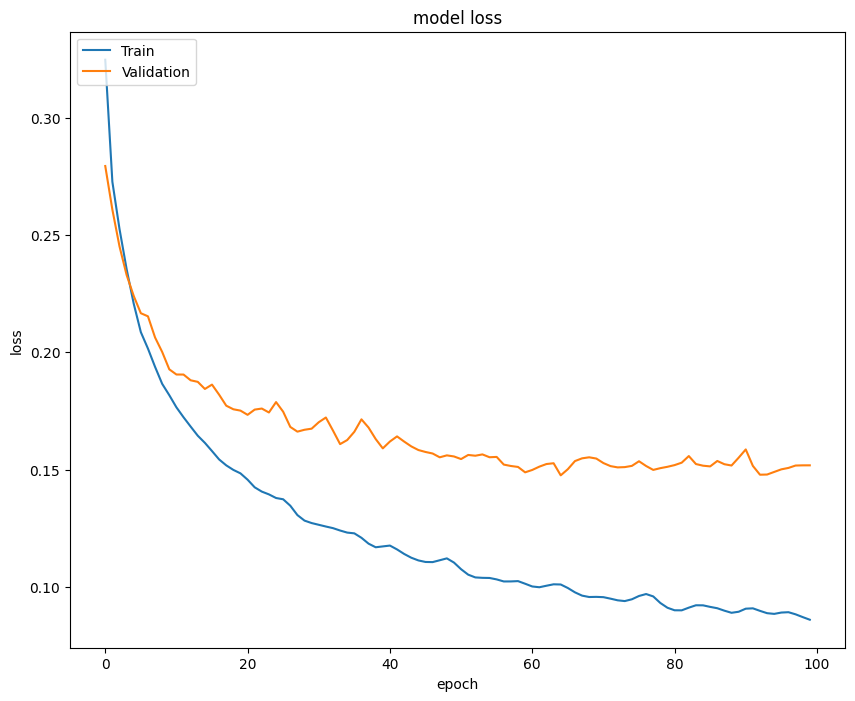

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# summarize history for loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## TEST SOME PRELIMARY RESULTS WITH TEST DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load model
import keras
model=keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/model1.h5')


In [ ]:
test = np.load(f'/content/drive/MyDrive/Colab Notebooks/UNet Model/test_dataset.npy')

In [ ]:
BATCH_SIZE = 1
def data_generator(data):
    for i in range(data.shape[0]):
        yield data[i]

def load(input):
  input_image = tf.convert_to_tensor(tf.reshape((input[...,0]-1)/254.0,[256,256,1]))
  real_image = tf.convert_to_tensor(tf.reshape(input[...,1],[256,256,1]))
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  return input_image, real_image

test_dataset = tf.data.Dataset.from_generator(lambda: data_generator(test), output_types=tf.float32)
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
import numpy as np
# Evaluate the model with the test dataset
loss, mae = model.evaluate(test_dataset, verbose=0)

# Calculate the correlation coefficient
y_true = []  # Ground truth precipitation rates
y_pred = []  # Predicted precipitation rates

for input_image, real_image in test_dataset:
    predictions = model.predict([input_image],  verbose=0)
    y_true.extend(real_image.numpy().flatten())
    y_pred.extend(predictions.flatten())

corr_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
print(f"Test Loss (MSE): {loss}, MAE: {mae}, Correlation: {corr_coefficient}")

Test Loss (MSE): 0.15227550268173218, MAE: 0.0952053964138031, Correlation: 0.8312742119831342


In [ ]:
# Set a precipitation threshold (e.g., 0.5) to convert predictions to binary values
threshold = 0.1

# Convert predictions to binary using the threshold
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred]
y_true_binary = [1 if ytrue >= threshold else 0 for ytrue in y_true]

# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
TP = sum((y_true_binary[i] == 1) and (y_pred_binary[i] == 1) for i in range(len(y_true)))
FP = sum((y_true_binary[i] == 0) and (y_pred_binary[i] == 1) for i in range(len(y_true)))
TN = sum((y_true_binary[i] == 0) and (y_pred_binary[i] == 0) for i in range(len(y_true)))
FN = sum((y_true_binary[i] == 1) and (y_pred_binary[i] == 0) for i in range(len(y_true)))

# Calculate Probability of Detection (POD), False Alarm Ratio (FAR), and Critical Success Index (CSI)
POD = TP / (TP + FN)
FAR = FP / (FP + TP)
CSI = TP / (TP + FN + FP)

print(f"Test Loss (MSE): {loss}, Test MAE: {mae}, Correlation: {corr_coefficient}")
print(f"Probability of Detection (POD): {POD}")
print(f"False Alarm Ratio (FAR): {FAR}")
print(f"Critical Success Index (CSI): {CSI}")

Test Loss (MSE): 0.15227550268173218, Test MAE: 0.0952053964138031, Correlation: 0.8312742119831342
Probability of Detection (POD): 0.7427388621951968
False Alarm Ratio (FAR): 0.4624758000915356
Critical Success Index (CSI): 0.45315517931346394
